<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_VAE/blob/main/CVAE_lsw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder**

Reference: Diederik P. Kingma and Max Welling, “Auto-Encoding Variational Bayes,” arXiv preprint arXiv:1312.6114, 2013.


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Input, Dense, Lambda, concatenate
import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Image directory
dir_image = '/content/drive/MyDrive/Colab/Graduation_paper/code_Professor/week2/pic'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Set training parameters**

In [33]:
# Parameters
learning_rate = 1e-3
training_epochs = 50
batch_size = 32
display_step = 5

###**Load MNIST data**
Set train & test data

In [34]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

y_train, y_test = to_categorical(y_train), to_categorical(y_test)
print(y_train.shape, y_test.shape)
# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(60000)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .shuffle(10000)
    .batch(batch_size)
)

(60000, 10) (10000, 10)


In [35]:
dim_x = np.shape(x_train)[1:]
dim_x

(28, 28, 1)

###**Set model**


In [36]:
class CVAE(keras.Model):
  """a basic vae class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(CVAE, self).__init__()
    self.__dict__.update(kwargs)

    self.dim_x_prod = reduce( (lambda x, y: x * y), self.dim_x)

    self.condition = self.cond

    # Set network
    self.enc_nn = keras.Sequential(self.enc_desc)
    self.dec_nn = keras.Sequential(self.dec_desc)

  def encode(self, x):
    input = concatenate([x, self.condition])
    mu, sigma_ = tf.split(self.enc_nn(input), num_or_size_splits=2, axis=1)
    sigma = keras.backend.softplus(sigma_) + 1e-6
    return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

  def decode(self, z):
    input = concatenate([z, self.condition])
    return self.dec_nn(input)

  def reconstruct(self, x):
    input = concatenate([x, self.condition])
    mu, _ = tf.split(self.enc_nn(input), num_or_size_splits=2, axis=1)
    return self.decode(mu)

  @tf.function
  def compute_loss(self, x):
    input = concatenate([x, self.condition])
    q_z = self.encode(input)
    z = q_z.sample()
    x_recon = self.decode(z)

    # Compute KL-divergence
    p_z = ds.MultivariateNormalDiag(
        loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
        )
    kl_div = ds.kl_divergence(q_z, p_z)
    loss_latent = tf.reduce_mean(tf.maximum(kl_div, 0))

    # Compute reconstruction loss
    _diffsq_x = tf.math.square(x - x_recon)
    diffsq_x = tf.reshape(_diffsq_x, [-1, self.dim_x_prod])
    _loss_recon = tf.reduce_sum(diffsq_x, axis=-1, keepdims=True)
    loss_recon = tf.reduce_mean(_loss_recon)

    return loss_latent, loss_recon

  def compute_gradients(self, x):
    input = concatenate([x, self.condition])
    with tf.GradientTape() as tape:
        loss_latent, loss_recon = self.compute_loss(input)
        loss_sum = loss_latent + loss_recon
    cg = tape.gradient(loss_sum, self.enc_nn.trainable_variables + 
                       self.dec_nn.trainable_variables)
    return cg, loss_latent, loss_recon
  
  @tf.function
  def train(self, x):
    """ Trains model. """
    input = concatenate([x, self.condition])
    cg, loss_latent, loss_recon = self.compute_gradients(input)
    self.optimizer.apply_gradients(zip(cg, self.enc_nn.trainable_variables + 
                                       self.dec_nn.trainable_variables))
    return loss_latent, loss_recon

In [51]:
dim_z = 2

enc_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
            keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Flatten(),
            keras.layers.Dense(units=dim_z*2)]

dec_desc = [keras.layers.Dense(units=7 * 7 * 64, input_shape=(4,), activation="relu"),
            keras.layers.Reshape(target_shape=(7, 7, 64)),
            keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="same", activation="sigmoid")
            ]

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# condition
condition = tf.keras.layers.Input(shape=(y_train.shape[1],))
condition

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_17')>

In [53]:
cvae = CVAE(dim_x=dim_x, enc_desc=enc_desc, dec_desc=dec_desc, optimizer=optimizer, cond=condition)

In [54]:
cvae.dec_nn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 3136)              15680     
_________________________________________________________________
reshape_11 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 28, 28, 1)         289       
Total params: 71,361
Trainable params: 71,361
Non-trainable params: 0
_________________________________________________________________


### Train model

In [39]:
# Test-data for plot
test_data_plot = next(iter(test_data))

import matplotlib.pyplot as plt

def plot_train(model, x, nex=6, zm=2, epoch=0):
  x_recon = model.reconstruct(x)
  x_sample = model.decode(tf.random.normal(shape=(batch_size, dim_z)))
  
  fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
  
  for axi, (dat, lab) in enumerate(zip([x, x_recon, x_sample],
                                       ["data", "data_recon", "data_sample"],)):
    for ex in range(nex):
      axs[axi, ex].matshow(
          dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
          )
      axs[axi, ex].axes.get_xaxis().set_ticks([])
      axs[axi, ex].axes.get_yaxis().set_ticks([])
      axs[axi, 0].set_ylabel(lab)

  plt.show()
  
  # Save fig
  figname2save = '{:s}/train_vae_new_z_{:d}_{:d}.png'.format(dir_image,dim_z,epoch)
  fig.savefig(figname2save)

  # Close fig
  plt.close()

In [40]:
# Select metrics to measure the loss of the model
train_loss_latent = keras.metrics.Mean(name='train_loss_latent')
train_loss_recon = keras.metrics.Mean(name='train_loss_recon')
test_loss_latent = keras.metrics.Mean(name='train_loss_latent')
test_loss_recon = keras.metrics.Mean(name='train_loss_recon')

Epoch 1, Train-Loss: [2.7340,44.0385], Test-Loss: [3.6329,37.9935]


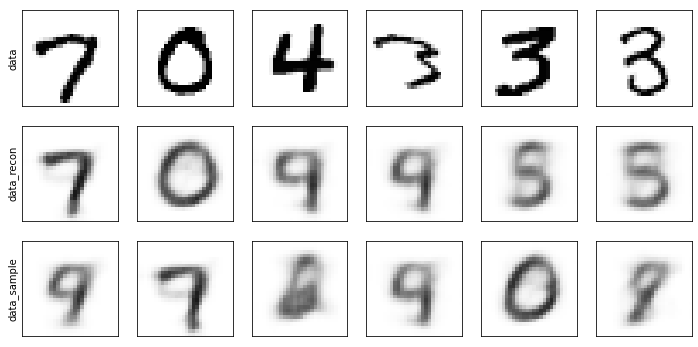

Epoch 2, Train-Loss: [3.8040,37.1967], Test-Loss: [4.1045,36.2647]
Epoch 3, Train-Loss: [4.0408,36.0177], Test-Loss: [4.0399,35.5513]
Epoch 4, Train-Loss: [4.1745,35.3837], Test-Loss: [4.4663,35.0617]
Epoch 5, Train-Loss: [4.2644,34.9634], Test-Loss: [4.2328,35.0946]
Epoch 6, Train-Loss: [4.3363,34.6546], Test-Loss: [4.1981,34.6187]


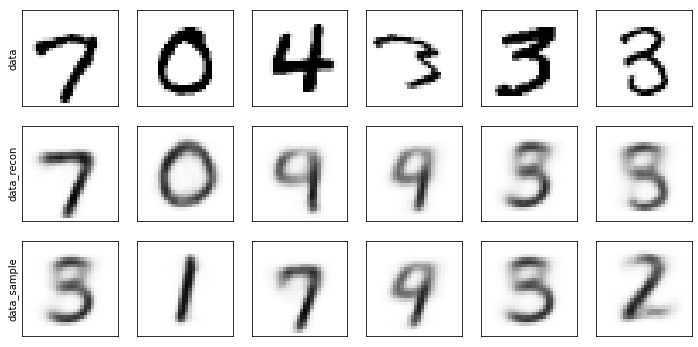

Epoch 7, Train-Loss: [4.3689,34.4064], Test-Loss: [4.4826,34.2521]
Epoch 8, Train-Loss: [4.4005,34.2007], Test-Loss: [4.4322,34.3093]
Epoch 9, Train-Loss: [4.4577,34.0483], Test-Loss: [4.6694,33.7994]
Epoch 10, Train-Loss: [4.4657,33.9150], Test-Loss: [4.4376,34.0196]
Epoch 11, Train-Loss: [4.5030,33.7904], Test-Loss: [4.4989,34.0065]


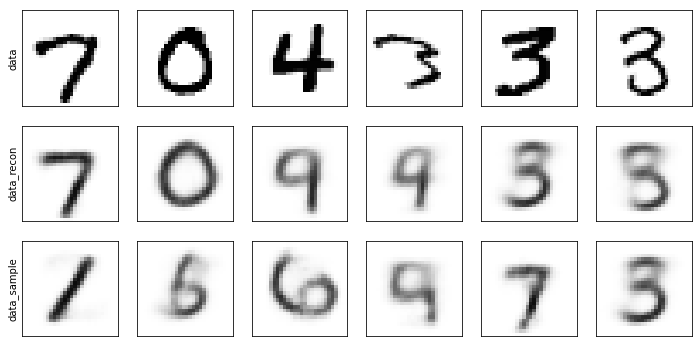

Epoch 12, Train-Loss: [4.5239,33.6885], Test-Loss: [4.5455,33.6928]
Epoch 13, Train-Loss: [4.5384,33.5661], Test-Loss: [4.6348,33.8166]
Epoch 14, Train-Loss: [4.5621,33.5346], Test-Loss: [4.8539,33.3878]
Epoch 15, Train-Loss: [4.5712,33.4578], Test-Loss: [4.5520,33.4732]
Epoch 16, Train-Loss: [4.5958,33.3809], Test-Loss: [4.6510,33.3933]


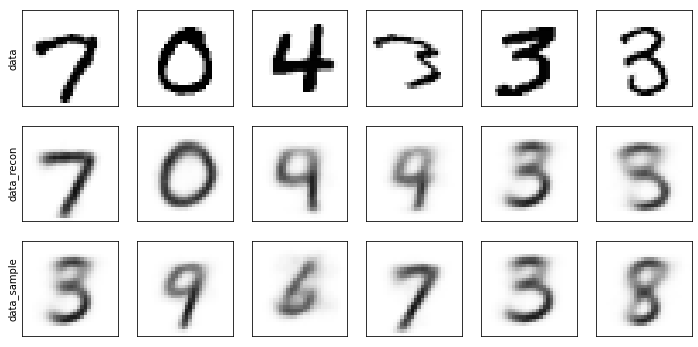

Epoch 17, Train-Loss: [4.5970,33.2988], Test-Loss: [4.4935,33.5591]
Epoch 18, Train-Loss: [4.6167,33.2446], Test-Loss: [4.6813,33.3873]
Epoch 19, Train-Loss: [4.6397,33.1956], Test-Loss: [4.4189,33.9251]
Epoch 20, Train-Loss: [4.6324,33.1375], Test-Loss: [4.6776,33.2066]
Epoch 21, Train-Loss: [4.6416,33.1116], Test-Loss: [4.6970,33.2139]


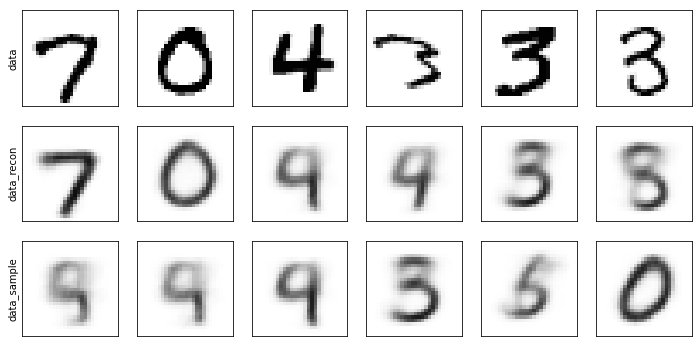

Epoch 22, Train-Loss: [4.6491,33.0557], Test-Loss: [4.5286,33.4035]
Epoch 23, Train-Loss: [4.6661,33.0206], Test-Loss: [4.6503,33.2535]
Epoch 24, Train-Loss: [4.6810,32.9584], Test-Loss: [4.6139,33.2268]
Epoch 25, Train-Loss: [4.6989,32.9026], Test-Loss: [4.9089,33.0597]
Epoch 26, Train-Loss: [4.6927,32.8598], Test-Loss: [4.6331,33.1737]


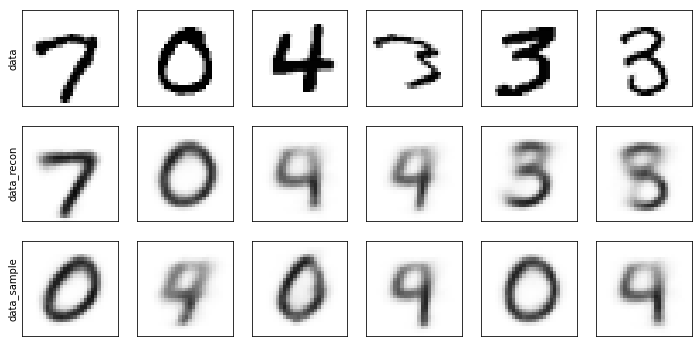

Epoch 27, Train-Loss: [4.7025,32.8212], Test-Loss: [4.6608,33.0276]
Epoch 28, Train-Loss: [4.7093,32.8128], Test-Loss: [4.8365,32.9818]
Epoch 29, Train-Loss: [4.7246,32.7645], Test-Loss: [4.6505,33.1763]
Epoch 30, Train-Loss: [4.7192,32.7339], Test-Loss: [4.7580,33.2065]
Epoch 31, Train-Loss: [4.7379,32.7059], Test-Loss: [4.7332,33.0425]


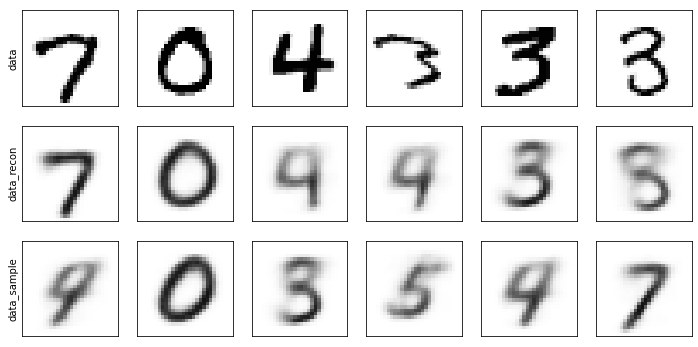

Epoch 32, Train-Loss: [4.7382,32.6742], Test-Loss: [4.7228,32.9591]
Epoch 33, Train-Loss: [4.7498,32.6521], Test-Loss: [4.5560,33.2746]
Epoch 34, Train-Loss: [4.7484,32.5995], Test-Loss: [4.5881,33.1249]
Epoch 35, Train-Loss: [4.7566,32.5798], Test-Loss: [4.8622,32.8138]
Epoch 36, Train-Loss: [4.7641,32.5671], Test-Loss: [4.6483,33.0738]


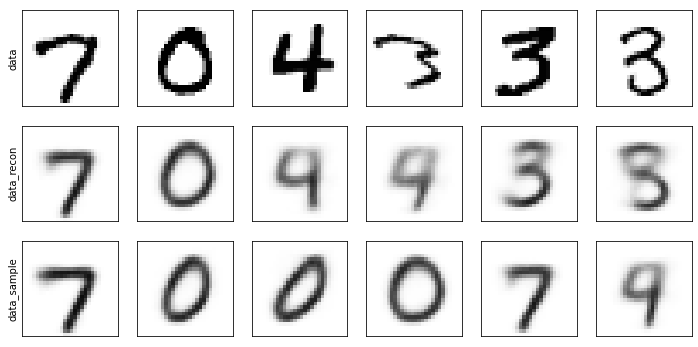

Epoch 37, Train-Loss: [4.7619,32.5354], Test-Loss: [4.8310,32.8406]
Epoch 38, Train-Loss: [4.7764,32.5203], Test-Loss: [4.7829,32.9524]
Epoch 39, Train-Loss: [4.7785,32.5037], Test-Loss: [4.7168,33.0346]
Epoch 40, Train-Loss: [4.7790,32.5117], Test-Loss: [4.8329,32.8971]
Epoch 41, Train-Loss: [4.7815,32.4589], Test-Loss: [4.8736,32.9230]


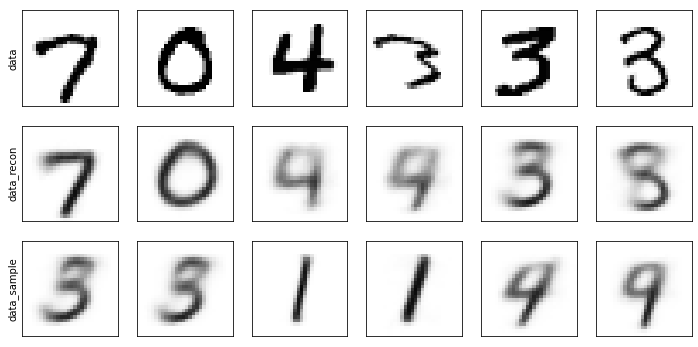

Epoch 42, Train-Loss: [4.8104,32.4439], Test-Loss: [4.7336,32.9190]
Epoch 43, Train-Loss: [4.8029,32.4122], Test-Loss: [4.6398,33.0824]
Epoch 44, Train-Loss: [4.8062,32.4221], Test-Loss: [4.7250,32.8407]
Epoch 45, Train-Loss: [4.8066,32.3764], Test-Loss: [4.8289,33.0486]
Epoch 46, Train-Loss: [4.8204,32.3886], Test-Loss: [4.8336,32.8519]


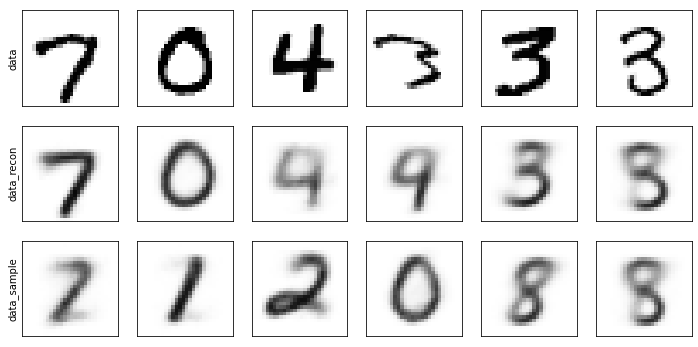

Epoch 47, Train-Loss: [4.8078,32.3451], Test-Loss: [4.6819,32.8455]
Epoch 48, Train-Loss: [4.8088,32.3428], Test-Loss: [4.9166,32.7131]
Epoch 49, Train-Loss: [4.8380,32.3088], Test-Loss: [4.8545,32.8095]
Epoch 50, Train-Loss: [4.8346,32.3025], Test-Loss: [4.8846,32.9154]


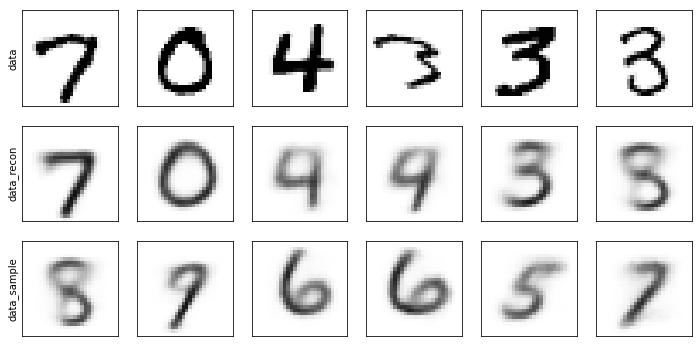

In [41]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch in train_data:
    loss_latent, loss_recon = vae.train(x_batch)
    train_loss_latent(loss_latent)
    train_loss_recon(loss_recon)

  for x_batch_t in test_data:
    loss_latent_t, loss_recon_t = vae.compute_loss(x_batch_t)
    test_loss_latent(loss_latent_t)
    test_loss_recon(loss_recon_t)

  template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(template.format(epoch+1, train_loss_latent.result(),
                        train_loss_recon.result(), test_loss_latent.result(),
                        test_loss_recon.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_train(vae, test_data_plot, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_loss_latent.reset_states()
  train_loss_recon.reset_states()
  test_loss_latent.reset_states()
  test_loss_recon.reset_states()

### Plot grid in 2D latent space

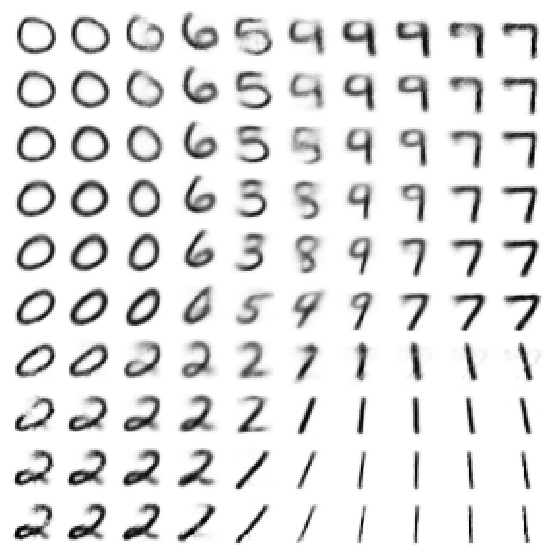

In [42]:
# Sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = vae.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# Fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

# Save fig
figname2save = '{:s}/vae_new_z{:d}_grid.png'.format(dir_image,dim_z)
fig.savefig(figname2save)